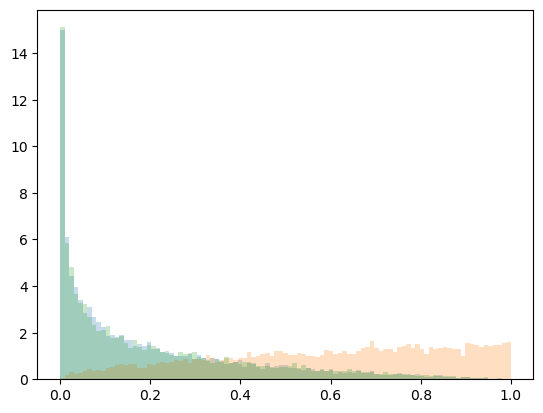

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt


n_states = 3

concentration = 0.5
stickiness = 1.0

alpha = np.ones((n_states,)) * concentration + (np.arange(n_states) == 1) * stickiness

p = scipy.stats.dirichlet.rvs(alpha, size=10000)

for i in range(n_states):
    plt.hist(p[:, i], bins=np.linspace(0, 1, 100), alpha=0.25, density=True)


In [2]:
transitions_count = scipy.stats.multinomial.rvs(1, p[0], size=5)

transitions_count.sum(axis=0)


array([0, 1, 4])

In [3]:
from src.estimate_transition import (
    dirichlet_neg_log_likelihood,
    dirichlet_gradient,
    dirichlet_hessian,
    jax_centered_log_softmax_forward,
    multinomial_neg_log_likelihood,
    multinomial_gradient,
    multinomial_hessian,
)
from scipy.optimize import minimize

n_coefficients = 1
n_samples = transitions_count.shape[0]


coefficients = np.zeros((n_coefficients * (n_states - 1),))
design_matrix = np.ones((n_samples, n_coefficients))
response = transitions_count.copy()

dirichlet_result = minimize(
    dirichlet_neg_log_likelihood,
    x0=coefficients,
    method="Newton-CG",
    jac=dirichlet_gradient,
    hess=dirichlet_hessian,
    args=(
        design_matrix,
        response,
        alpha,
        0.0,
    ),
    options={"disp": True, "maxiter": 100},
)

multinomial_result = minimize(
    multinomial_neg_log_likelihood,
    x0=coefficients,
    method="Newton-CG",
    jac=multinomial_gradient,
    hess=multinomial_hessian,
    args=(
        design_matrix,
        response,
        0.0,
    ),
    options={"disp": True, "maxiter": 100},
)

multinomial_estimated_probs = np.exp(
        jax_centered_log_softmax_forward(
            multinomial_result.x.reshape((n_coefficients, n_states - 1))
        )
)

dirichlet_estimated_probs = np.exp(
        jax_centered_log_softmax_forward(
            dirichlet_result.x.reshape((n_coefficients, n_states - 1))
        )
)
multinomial_estimated_probs, dirichlet_estimated_probs

         Current function value: -826.826172
         Iterations: 100
         Function evaluations: 125
         Gradient evaluations: 122
         Hessian evaluations: 100
Optimization terminated successfully.
         Current function value: 0.500403
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
         Hessian evaluations: 15


(array([[5.1789385e-07, 1.9999969e-01, 7.9999983e-01]], dtype=float32),
 array([[0.       , 0.4607563, 0.5392437]], dtype=float32))

In [4]:
p[0]

array([0.02638058, 0.49153313, 0.4820863 ])

In [5]:
np.abs(p[0] - multinomial_estimated_probs)

array([[0.02638006, 0.29153344, 0.31791354]])

In [6]:
np.abs(p[0] - dirichlet_estimated_probs)

array([[0.02638058, 0.03077682, 0.0571574 ]])

In [7]:
np.abs(p[0] - multinomial_estimated_probs) > np.abs(p[0] - dirichlet_estimated_probs)

array([[False,  True,  True]])

In [8]:
alpha

array([0.5, 1.5, 0.5])